In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])

In [3]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands
0,2022-01-01,25,187.148310,79439.490943,3972
1,2022-01-02,21,651.090018,46402.445157,2581
2,2022-01-03,10,2469.903372,33963.973956,2096
3,2022-01-04,10,-146.716214,13660.124678,1361
4,2022-01-05,14,-822.788468,59365.320499,2295


<Axes: xlabel='Date'>

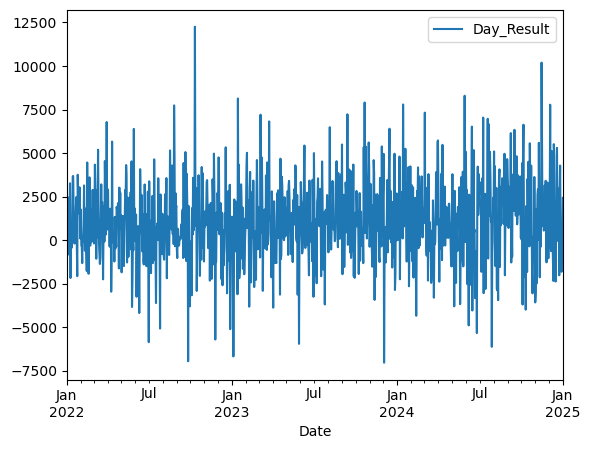

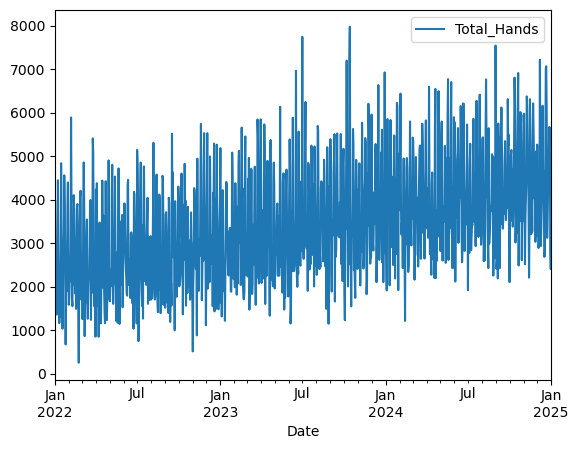

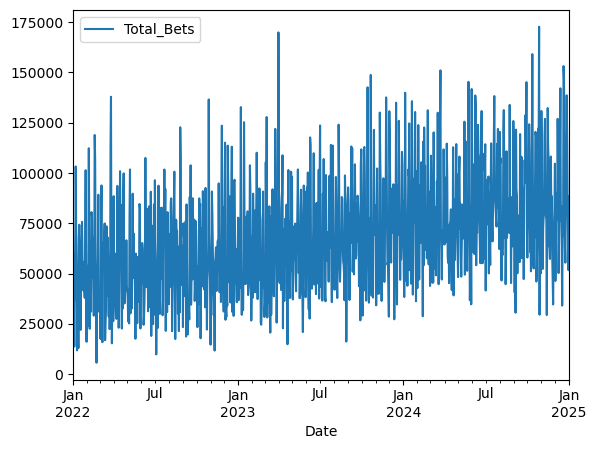

In [4]:
casino_fig[:].plot(x="Date", y ="Day_Result")
casino_fig[:].plot(x="Date", y ="Total_Hands")
casino_fig[:].plot(x="Date", y ="Total_Bets")


## Приемы для анализа ряда

#### Скользящее среднее окно



[pandas.Series.rolling.html](https://pandas.pydata.org/docs/reference/api/pandas.Series.rolling.html)

``` python
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()
```

In [5]:
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()

<Axes: xlabel='Date'>

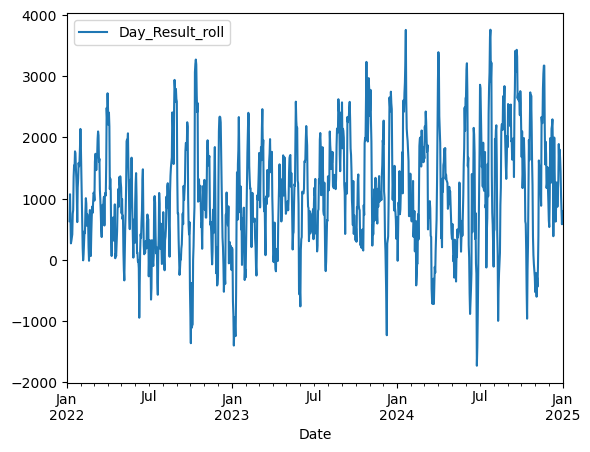

In [6]:
casino_fig.plot(x="Date", y ="Day_Result_roll")


#### Скользим по медианам

[scipy.signal.medfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.medfilt.html)


```python
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=7)
```

In [7]:
from scipy.signal import medfilt

In [8]:
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=7)

<Axes: xlabel='Date'>

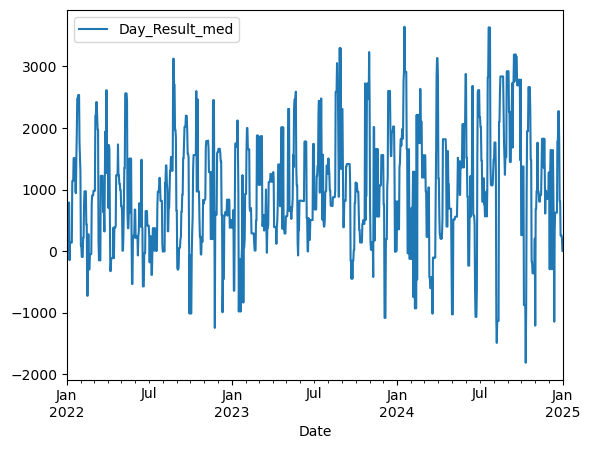

In [9]:
casino_fig.plot(x="Date", y ="Day_Result_med")

## Экспон-е сглаживание

[pandas.Series.ewm](https://pandas.pydata.org/docs/reference/api/pandas.Series.ewm.html)

```python
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()

```


In [10]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()


<Axes: xlabel='Date'>

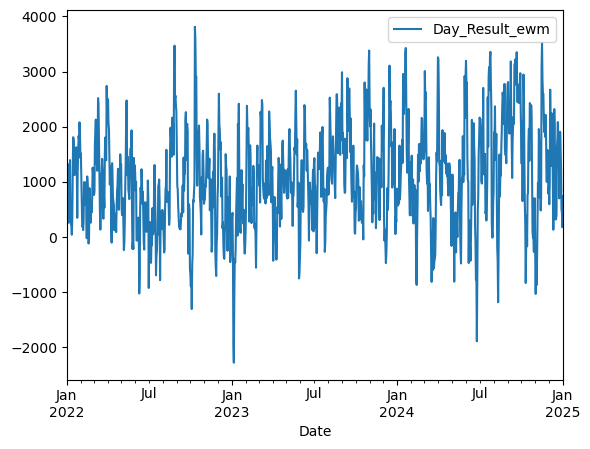

In [11]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [12]:
casino_fig['Total_Bets_ewm'] = casino_fig['Total_Bets'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

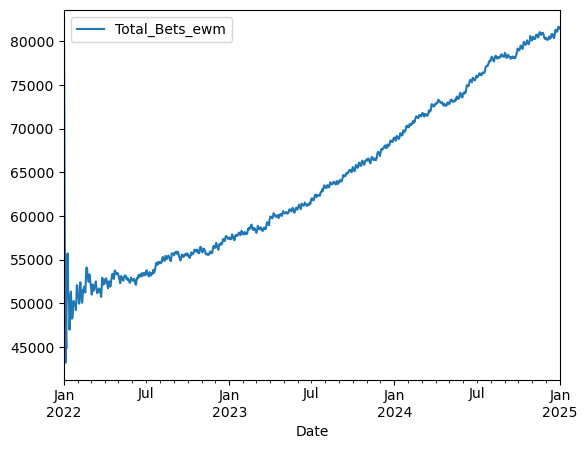

In [13]:
casino_fig.plot(x="Date", y ="Total_Bets_ewm")


### Линейная аппроксимация

[scipy.stats.linregress](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html)


In [14]:
from scipy import stats

In [15]:
slope, intercept, r, p, std_err = stats.linregress(casino_fig.index,casino_fig['Total_Bets'])

In [16]:
casino_fig['trend_bet']= slope*casino_fig.index+intercept

<Axes: xlabel='Date'>

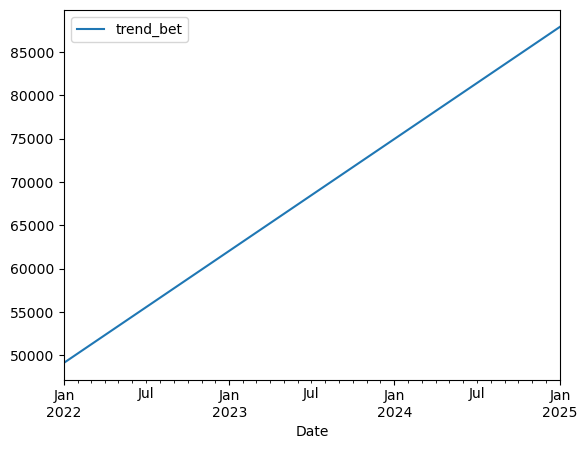

In [17]:
casino_fig.plot(x="Date", y ="trend_bet")

In [19]:
casino_fig['trend_free'] = casino_fig['Total_Bets']-casino_fig['trend_bet'] + intercept

<Axes: xlabel='Date'>

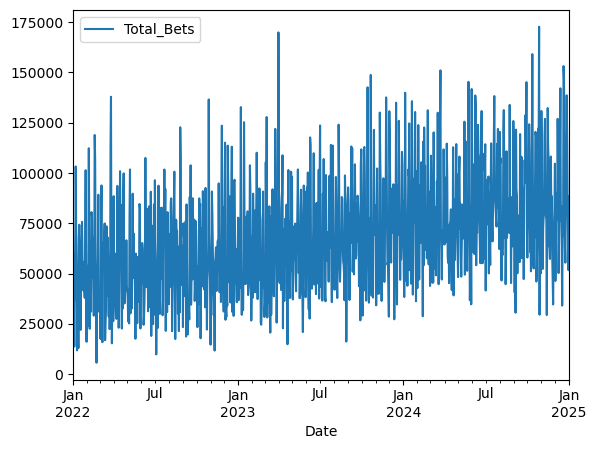

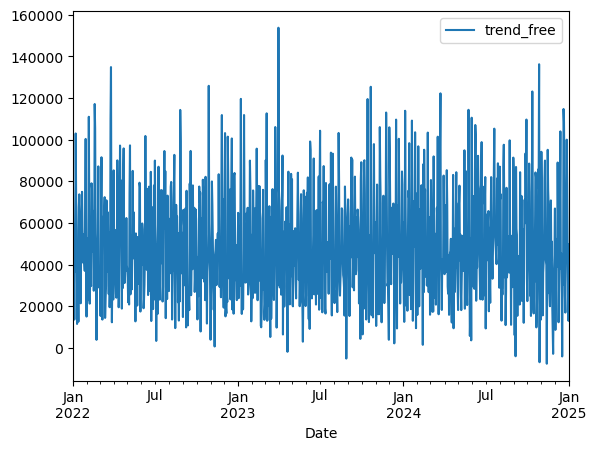

In [20]:
casino_fig.plot(x="Date", y ="Total_Bets")
casino_fig.plot(x="Date", y ="trend_free")

### Аппроксимация многочленом

`np.polyfit`

— это функция в библиотеке NumPy для Python, которая находит коэффициенты полинома степени 𝑛 , наилучшим образом соответствующего набору данных (𝑥,𝑦)  
с использованием метода наименьших квадратов.

In [27]:
# Perform cubic fit
coefficients = np.polyfit(casino_fig.index,casino_fig['Total_Bets'], 1)
print(coefficients)

[3.53631292e+01 4.91505448e+04]


In [28]:
p = np.poly1d(coefficients) # создаём полином

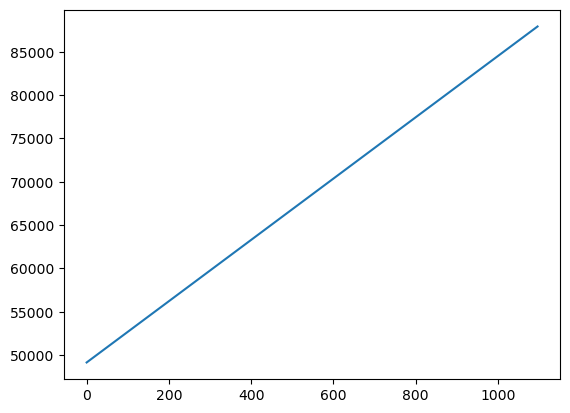

In [29]:
plt.plot(casino_fig.index,p(casino_fig.index))

### Самый простой способ анализа временного ряда с сезоностью.

In [30]:
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek 

In [31]:
casino_fig['week_day']

0       5
1       6
2       0
3       1
4       2
       ..
1092    5
1093    6
1094    0
1095    1
1096    2
Name: week_day, Length: 1097, dtype: int32

#### Группируем по дням недели.


In [32]:
casino_fig.groupby('week_day')['trend_free'].mean()

week_day
0    29252.609461
1    34415.334657
2    41682.106662
3    33496.191497
4    73210.827668
5    75258.361038
6    56791.923593
Name: trend_free, dtype: float64

In [34]:
bet_df =casino_fig.groupby('week_day')['trend_free'].agg([ 'mean','std'])
bet_df

,mean,std
week_day,,
0,29252.609461,15631.885003
1,34415.334657,16693.080837
2,41682.106662,18939.224540
3,33496.191497,16172.567267
4,73210.827668,21984.986981
5,75258.361038,21772.283772
6,56791.923593,20556.896289


### по каждому дню находим СКО

In [35]:
bet_df['low_res'] = bet_df['mean'] - 2* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 2* bet_df['std']

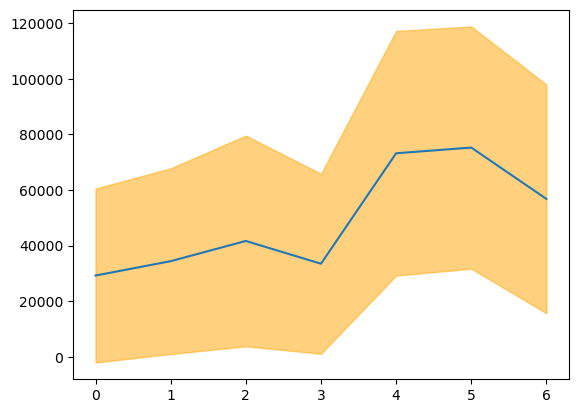

In [36]:
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')

In [37]:
bet_df.index

Index([0, 1, 2, 3, 4, 5, 6], dtype='int32', name='week_day')

In [38]:
casino_fig.tail(10)

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm,Total_Bets_ewm,trend_bet,trend_free,week_day
1087,2024-12-23,22,1784.144598,63872.177984,3125,1892.523111,2273.884814,1606.710635,81219.220283,87590.266226,25432.456562,0
1088,2024-12-24,31,-2016.836282,55393.548538,3631,1553.763365,1784.144598,700.823905,81077.733967,87625.629355,16918.463986,1
1089,2024-12-25,26,2359.211742,87703.514513,4221,1801.432579,810.659376,1115.420865,81114.032892,87660.992484,49193.066832,2
1090,2024-12-26,25,4282.533647,84153.125583,4302,1656.536125,810.659376,1907.199060,81130.682139,87696.355613,45607.314773,3
1091,2024-12-27,28,810.659376,138594.152899,5254,1447.503920,252.717789,1633.064139,81445.483412,87731.718743,100012.978960,4
1092,2024-12-28,43,205.020732,116751.304646,5676,1051.937194,252.717789,1276.053287,81638.896094,87767.081872,78134.767577,5
1093,2024-12-29,41,-1815.764214,85159.763939,5381,801.281371,252.717789,503.098912,81658.183881,87802.445001,46507.863742,6
1094,2024-12-30,23,252.717789,68613.055283,2875,582.506113,205.020732,440.503631,81586.721891,87837.808130,29925.791956,0
1095,2024-12-31,31,-612.588136,51654.487776,2406,783.112991,0.000000,177.230690,81422.753561,87873.171259,12931.861320,1
1096,2025-01-01,23,2424.047727,88497.590950,4310,792.375275,0.000000,738.934949,81461.508891,87908.534389,49739.601365,2


In [ ]:
casino_fig['Total_Bets'][1087:1094]

In [39]:
bet_df['mean']  = casino_fig.index[1087:1094]*slope + bet_df['mean']

In [ ]:
# bet_df['low_res'] = bet_df['mean'] - 3* bet_df['std']
# bet_df['high_res'] = bet_df['mean'] + 3* bet_df['std']

In [ ]:
# plt.plot(bet_df.index ,casino_fig['Total_Bets'][1087:1094] )
# plt.plot(bet_df.index ,bet_df['mean'] )
# plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')